## Introducción

El objetivo de esta tarea es evaluar la performance de diferentes modelos de deep learning sobre un problema de clasificación de escenas.

**Dataset**

El dataset a ser utilizado es **Imagenette**, una versión simplificada de ImageNet que consiste de 10 clases. Pueden encontrar más información y descargarlo en el siguiente [link](https://pytorch.org/vision/main/generated/torchvision.datasets.Imagenette.html).

In [ ]:
!pip install torchinfo

In [ ]:
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.8/313.8 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.9 MB/s eta 0:00:00


In [ ]:
import random
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import v2 as T # paquete que nos permite transformar imagenes
from torchvision.io import read_image, ImageReadMode
from torchvision import transforms

from torchinfo import summary

import os
from pathlib import Path
import matplotlib.pyplot as plt

from collections import Counter

import wandb

from IPython.display import Image, display

from utils import (
    train,
    plot_taining,
    model_calassification_report,
    show_tensor_image,
    show_tensor_images,
    evaluate
)

In [ ]:
SEED = 34

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS

NUM_WORKERS = max(os.cpu_count() - 1, 1)  # número de workers para cargar los datos
BATCH_SIZE = 64  # tamaño del batch

print(f"Device: {DEVICE}")
print(f"Num Workers: {NUM_WORKERS}")

Device: cuda
Num Workers: 11


# **Carga y exploración del dataset Imagenette**

In [ ]:
DATA_DIR = Path("data")

def get_dataloaders(train_transf, test_transf, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, download_data=False, details=False):
    # descargamos el dataset Imagenette (si no lo tenemos ya)
    train_dataset = datasets.Imagenette(
        DATA_DIR, split="train", download=download_data, transform=train_transf
    )

    test_dataset = datasets.Imagenette(
        DATA_DIR, split="val", download=False, transform=test_transf
    )

    num_classes = len(train_dataset.classes)

    if details == True:
      labels = [label for _, label in train_dataset]
      class_counts = Counter(labels)
      name_classes = train_dataset.classes
      print("----> Train dataset <----")
      for class_idx, count in class_counts.items():
        print(f"Clase {name_classes[class_idx]}: {count} elementos")
      print(f"\nNúmero total de clases: {num_classes}")

      labels = [label for _, label in test_dataset]
      class_counts = Counter(labels)
      name_classes = test_dataset.classes
      print("\n----> Test dataset <----")
      for class_idx, count in class_counts.items():
        print(f"Clase {name_classes[class_idx]}: {count} elementos")
      print(f"\nNúmero total de clases: {num_classes}")

    # dividimos el dataset de entrenamiento en entrenamiento y validación
    train_size = int(0.8 * len(train_dataset))
    valid_size = len(train_dataset) - train_size
    train_dataset, validation_dataset = random_split(
        train_dataset,
        [train_size, valid_size],
        generator=torch.Generator().manual_seed(SEED),  # fijamos la semilla
    )

    validation_dataset.transform = test_transf

    # creamos los dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )

    val_loader = DataLoader(
        validation_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    return train_loader, val_loader, test_loader, num_classes, train_dataset

In [ ]:
_, _, _, NUM_CLASSES, train_dataset = get_dataloaders(None, None, download_data=True, details=True)

100%|██████████| 1557161267/1557161267 [01:34<00:00, 16499072.22it/s]


Extracting data/imagenette2.tgz to data
----> Train dataset <----
Clase ('tench', 'Tinca tinca'): 963 elementos
Clase ('English springer', 'English springer spaniel'): 955 elementos
Clase ('cassette player',): 993 elementos
Clase ('chain saw', 'chainsaw'): 858 elementos
Clase ('church', 'church building'): 941 elementos
Clase ('French horn', 'horn'): 956 elementos
Clase ('garbage truck', 'dustcart'): 961 elementos
Clase ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'): 931 elementos
Clase ('golf ball',): 951 elementos
Clase ('parachute', 'chute'): 960 elementos

Número total de clases: 10

----> Test dataset <----
Clase ('tench', 'Tinca tinca'): 387 elementos
Clase ('English springer', 'English springer spaniel'): 395 elementos
Clase ('cassette player',): 357 elementos
Clase ('chain saw', 'chainsaw'): 386 elementos
Clase ('church', 'church building'): 409 elementos
Clase ('French horn', 'horn'): 394 elementos
Clase ('garbage truck', 'dustcart'): 389 elementos
Clase ('ga

In [ ]:
def show_images(images, title="Imagenette Sample"):
    n = len(images)
    rows = math.floor(math.sqrt(n))
    columns = math.ceil(n / rows)

    fig, axs = plt.subplots(rows, columns)
    fig.suptitle(title, fontsize=14, y=.95)

    for i in range(rows):
        for j in range(columns):
            index = i*columns + j
            if index < n:
                axs[i,j].imshow(images[index])
            axs[i,j].axis('off')

    plt.show()

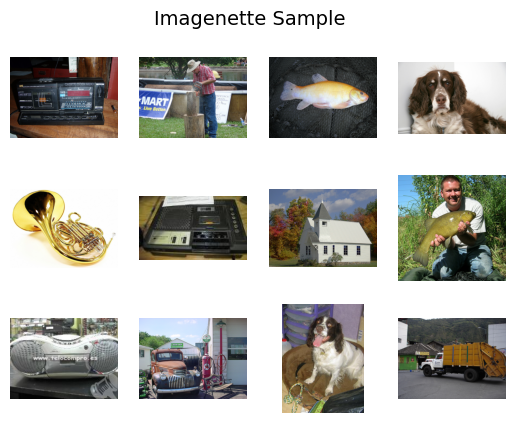

In [ ]:
images = []
for _ in range(12):
    image, label = train_dataset[random.randrange(len(train_dataset))]
    images.append(image)
show_images(images)

# **Analisis del Dataset Imaginette**

El dataset imaginette es un dataset que contiene imagenes de alta definicion de al menos 224x224 pixeles. Como vimos más arriba contiene 10 clase balanceadas con etiquetas varaibles.

# **Data Augmentation**
Para mejorar el proceso de entrenamiento de nuestro modelo convolucional, aplicaremos una serie de transformaciones a nuestro dataset de imágenes. Estas transformaciones permiten que el modelo generalice mejor y aprenda características más robustas de cada clase.

1. Redimensionamiento: Como las imágenes tienen diferentes resoluciones, las ajustaremos todas a un tamaño uniforme de 128x128 píxeles. Esto asegura que el modelo pueda procesarlas de manera consistente.

2. Normalización de píxeles: Normalizaremos los valores de los píxeles de las imágenes usando el promedio y la desviación estándar de todo el dataset. Esto ayuda a estandarizar los valores de los píxeles, lo que facilita el aprendizaje del modelo.

3. Random Horizontal Flip: Esta transformación invierte horizontalmente las imágenes de forma aleatoria. Esto es útil para aumentar la variabilidad del dataset sin alterar las clases de las imágenes.

4. Random Rotation (40 grados): Rotaremos aleatoriamente las imágenes hasta un máximo de 40 grados. Esto hace que el modelo se vuelva más robusto a las rotaciones leves en las imágenes.

5. Ruido Gaussiano: Añadiremos ruido gaussiano a las imágenes para que el modelo aprenda a distinguir características importantes a pesar de pequeñas variaciones aleatorias.

En resumen, aplicaremos las siguientes transformaciones:

Redimensionar las imágenes a 128x128 píxeles.
Normalizar los valores de los píxeles usando el promedio y la desviación estándar del dataset.
Aplicar Random Horizontal Flip.
Rotar las imágenes hasta 40 grados aleatoriamente.
Añadir ruido gaussiano.
Estas transformaciones aumentan la diversidad del dataset sin necesidad de recolectar más imágenes, lo que mejora el rendimiento general del modelo.




# Cálculo de el promedio y desviación estandar del dataset.

In [ ]:
from pathlib import Path
import cv2
import numpy as np

# Ajusta esta ruta a la ubicación de tu dataset
imageFilesDir = Path('data/imagenette2/train')

# Usa '**/*.JPEG' para buscar en todas las subcarpetas
files = list(imageFilesDir.glob('**/*.JPEG'))

# Inicialización de variables
mean_rgb = np.zeros(3)  # Para las medias por canal (R, G, B)
stdTemp_rgb = np.zeros(3)  # Para la varianza por canal (R, G, B)

mean_global = 0.0  # Para la media global
stdTemp_global = 0.0  # Para la varianza global

numPixels = 0  # Total de píxeles en todas las imágenes (para el cálculo global)
numSamples = len(files)

# Primer bucle: calcular medias
for i, file in enumerate(files):
    im = cv2.imread(str(file))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = im.astype(float) / 255.

    # Sumar medias por canal (R, G, B)
    mean_rgb += np.mean(im, axis=(0, 1))

    # Sumar todos los valores de píxeles para la media global
    mean_global += np.sum(im)

    # Aumentar el contador de píxeles
    numPixels += im.size  # Total de píxeles (alto * ancho * 3)

# Dividir para obtener las medias finales
mean_rgb /= numSamples  # Media por canal (R, G, B)
mean_global /= numPixels  # Media global

# Segundo bucle: calcular desviación estándar
for i, file in enumerate(files):
    im = cv2.imread(str(file))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = im.astype(float) / 255.

    # Calcular las diferencias cuadradas para la desviación estándar por canal (R, G, B)
    stdTemp_rgb += np.mean((im - mean_rgb) ** 2, axis=(0, 1))

    # Calcular las diferencias cuadradas para la desviación estándar global
    stdTemp_global += np.sum((im - mean_global) ** 2)

# Calcular desviaciones estándar finales
std_rgb = np.sqrt(stdTemp_rgb / numSamples)  # Desviación estándar por canal (R, G, B)
std_global = np.sqrt(stdTemp_global / numPixels)  # Desviación estándar global

# Resultados
print("Media por canal (R, G, B):", mean_rgb)
print("Desviación estándar por canal (R, G, B):", std_rgb)
print("Media global:", mean_global)
print("Desviación estándar global:", std_global)

Media por canal (R, G, B): [0.46252462 0.45800934 0.4294821 ]
Desviación estándar por canal (R, G, B): [0.28974668 0.28592404 0.30813646]
Media global: 0.44792716724704273
Desviación estándar global: 0.2916949398510731


In [ ]:
# Media y Desviación Estandar Global
mean_global = 0.4479271672470407
std_global = 0.2916949398510727

# Media y Desviación Estandar RGB
mean_rgb = [0.46252462, 0.45800934, 0.4294821]
std_rgb = [0.28974668, 0.28592404, 0.30813646]

# Agregamos agumentación a nuestros transformers.

In [ ]:
transforms_aug = T.Compose(
    [
        T.Resize((128, 128)),
        T.ToTensor(),  # Convierte la imagen a tensor antes de aplicar ruido
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(degrees=45),
        T.GaussianNoise(mean=mean_global, sigma=std_global),
        T.Normalize(mean=mean_rgb, std=std_rgb),
    ]
)


transform_no_aug = T.Compose(
    [
        T.Resize((128, 128)),
        T.ToTensor(),
        T.Normalize(mean=mean_rgb, std=std_rgb),
    ]
)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


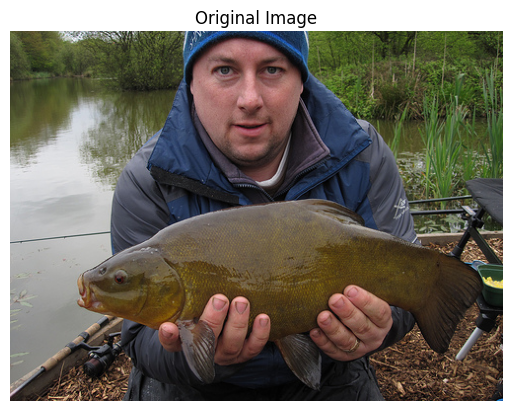

In [ ]:
img = read_image("/content/data/imagenette2/train/n01440764/ILSVRC2012_val_00024327.JPEG")
show_tensor_image(img, title="Original Image")

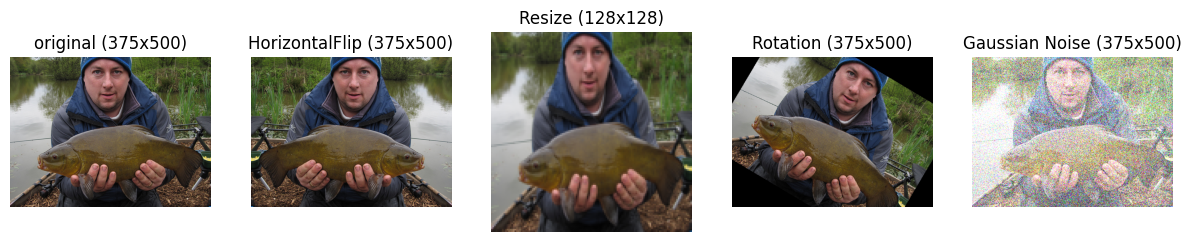

In [ ]:
img = T.ConvertImageDtype(torch.float)(img)

img_res = T.Resize((128, 128))(img)
img_rhf = T.RandomHorizontalFlip(p=1)(img)
img_rr = T.RandomRotation(degrees=40)(img)
img_gn = T.GaussianNoise(mean=mean_global, sigma=std_global)(img)

show_tensor_images(
    [img, img_rhf, img_res, img_rr, img_gn],
    titles=[
        f"original ({img.shape[-2]}x{img.shape[-1]})",
        f"HorizontalFlip ({img_rhf.shape[-2]}x{img_rhf.shape[-1]})",
        f"Resize ({img_res.shape[-2]}x{img_res.shape[-1]})",
        f"Rotation ({img_rr.shape[-2]}x{img_rr.shape[-1]})",
        f"Gaussian Noise ({img_gn.shape[-2]}x{img_gn.shape[-1]})"
    ],
)

# **Modelo Base: CNN Model - LeNet**

Utilizamos el modelo base de CNN para comprobar que nuestras transformaciones surten efecto positivo.

In [ ]:
class LeNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(LeNet, self).__init__()
        self.c1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5)
        self.s2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.c3 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.s4 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.c5 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5)
        self.avgpool = nn.AdaptiveAvgPool2d((5, 5))
        self.f6 = nn.Linear(in_features=120 * 5 * 5, out_features=84)
        self.output = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.tanh(self.c1(x))
        x = self.s2(x)
        x = F.tanh(self.c3(x))
        x = self.s4(x)
        x = F.tanh(self.c5(x))
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = F.tanh(self.f6(x))
        x = self.output(x)
        return x

summary(LeNet(3, NUM_CLASSES), input_size=(BATCH_SIZE, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [64, 10]                  --
├─Conv2d: 1-1                            [64, 6, 124, 124]         456
├─AvgPool2d: 1-2                         [64, 6, 62, 62]           --
├─Conv2d: 1-3                            [64, 16, 58, 58]          2,416
├─AvgPool2d: 1-4                         [64, 16, 29, 29]          --
├─Conv2d: 1-5                            [64, 120, 25, 25]         48,120
├─AdaptiveAvgPool2d: 1-6                 [64, 120, 5, 5]           --
├─Linear: 1-7                            [64, 84]                  252,084
├─Linear: 1-8                            [64, 10]                  850
Total params: 303,926
Trainable params: 303,926
Non-trainable params: 0
Total mult-adds (G): 2.91
Input size (MB): 12.58
Forward/backward pass size (MB): 113.24
Params size (MB): 1.22
Estimated Total Size (MB): 127.04

In [ ]:
LR = 0.001
EPOCHS = 50

CRITERION = nn.CrossEntropyLoss().to(DEVICE)

In [ ]:
letnet_model = LeNet(3, NUM_CLASSES).to(DEVICE)
optimizer = optim.Adam(letnet_model.parameters(), lr=LR)


train_loader, val_loader, test_loader, _, _ = get_dataloaders(
    transform_no_aug, transform_no_aug
)

Epoch: 001 | Train Loss: 1.87807 | Val Loss: 1.71696
Epoch: 002 | Train Loss: 1.67951 | Val Loss: 1.65179
Epoch: 003 | Train Loss: 1.60691 | Val Loss: 1.65443
Epoch: 004 | Train Loss: 1.55373 | Val Loss: 1.60173
Epoch: 005 | Train Loss: 1.49128 | Val Loss: 1.56102
Epoch: 006 | Train Loss: 1.44397 | Val Loss: 1.54154
Epoch: 007 | Train Loss: 1.39172 | Val Loss: 1.53412
Epoch: 008 | Train Loss: 1.34367 | Val Loss: 1.55341
Epoch: 009 | Train Loss: 1.29575 | Val Loss: 1.50623
Epoch: 010 | Train Loss: 1.24061 | Val Loss: 1.51936
Epoch: 011 | Train Loss: 1.19054 | Val Loss: 1.52127
Epoch: 012 | Train Loss: 1.13277 | Val Loss: 1.52191
Epoch: 013 | Train Loss: 1.07933 | Val Loss: 1.50945
Epoch: 014 | Train Loss: 1.02116 | Val Loss: 1.55908
Detener entrenamiento en la época 13, la mejor pérdida fue 1.50623


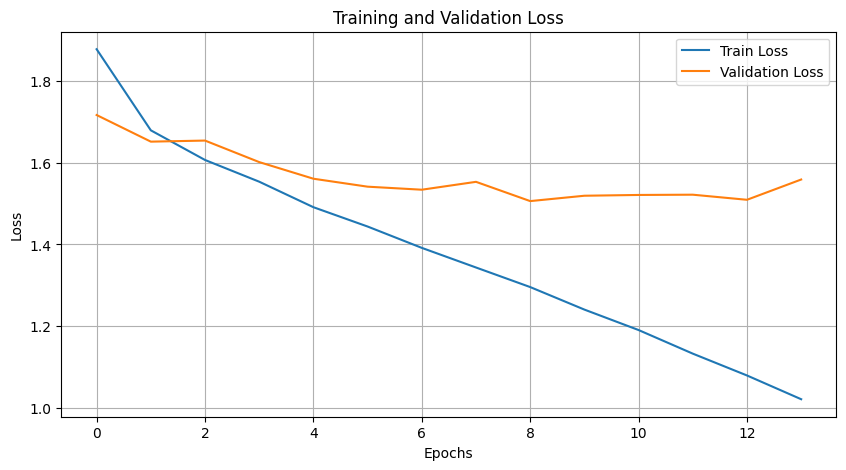

In [ ]:
train_errors_ln_nda, val_errors_ln_nda = train(
    model=letnet_model,
    optimizer=optimizer,
    criterion=CRITERION,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    do_early_stopping=True,
    patience=5,
    epochs=EPOCHS,
)

plot_taining(train_errors_ln_nda, val_errors_ln_nda)

In [ ]:
model_calassification_report(letnet_model, test_loader, DEVICE, NUM_CLASSES)

Accuracy: 0.4810

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.69      0.60      0.64       387
           1       0.37      0.51      0.42       395
           2       0.49      0.42      0.45       357
           3       0.35      0.19      0.25       386
           4       0.46      0.53      0.49       409
           5       0.42      0.48      0.45       394
           6       0.54      0.56      0.55       389
           7       0.38      0.35      0.36       419
           8       0.46      0.54      0.50       399
           9       0.71      0.63      0.67       390

    accuracy                           0.48      3925
   macro avg       0.49      0.48      0.48      3925
weighted avg       0.48      0.48      0.48      3925



In [ ]:
letnet_model = LeNet(3, NUM_CLASSES).to(DEVICE)
optimizer = optim.Adam(letnet_model.parameters(), lr=LR)


train_loader, val_loader, test_loader, _, _ = get_dataloaders(
    transforms_aug, transform_no_aug
)

Epoch: 001 | Train Loss: 2.01292 | Val Loss: 1.84866
Epoch: 002 | Train Loss: 1.83051 | Val Loss: 1.84062
Epoch: 003 | Train Loss: 1.81205 | Val Loss: 1.74602
Epoch: 004 | Train Loss: 1.74147 | Val Loss: 1.76368
Epoch: 005 | Train Loss: 1.73925 | Val Loss: 1.79239
Epoch: 006 | Train Loss: 1.73517 | Val Loss: 1.75488
Epoch: 007 | Train Loss: 1.68734 | Val Loss: 1.70172
Epoch: 008 | Train Loss: 1.67906 | Val Loss: 1.72869
Epoch: 009 | Train Loss: 1.66822 | Val Loss: 1.68833
Epoch: 010 | Train Loss: 1.65440 | Val Loss: 1.66943
Epoch: 011 | Train Loss: 1.66045 | Val Loss: 1.66475
Epoch: 012 | Train Loss: 1.62877 | Val Loss: 1.64952
Epoch: 013 | Train Loss: 1.64683 | Val Loss: 1.67632
Epoch: 014 | Train Loss: 1.59960 | Val Loss: 1.63406
Epoch: 015 | Train Loss: 1.62629 | Val Loss: 1.72213
Epoch: 016 | Train Loss: 1.60657 | Val Loss: 1.64534
Epoch: 017 | Train Loss: 1.59282 | Val Loss: 1.63097
Epoch: 018 | Train Loss: 1.58963 | Val Loss: 1.65199
Epoch: 019 | Train Loss: 1.56998 | Val Loss: 1

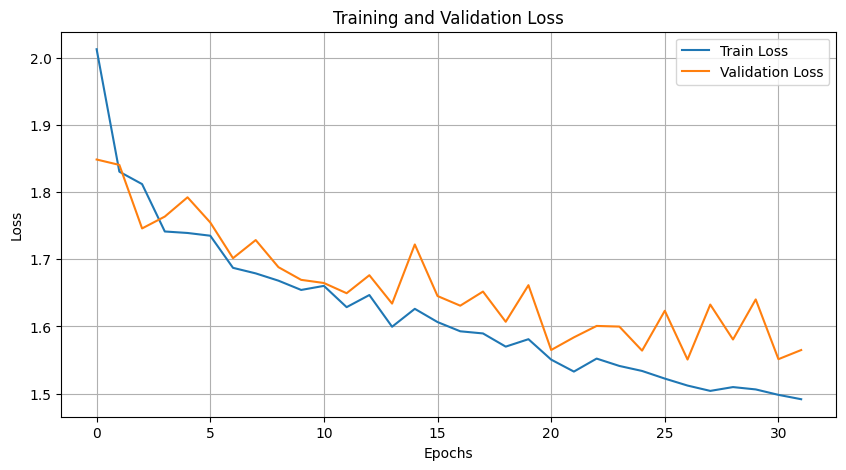

In [ ]:
train_errors_ln_nda, val_errors_ln_nda = train(
    model=letnet_model,
    optimizer=optimizer,
    criterion=CRITERION,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    do_early_stopping=True,
    patience=5,
    epochs=EPOCHS,
)

plot_taining(train_errors_ln_nda, val_errors_ln_nda)

In [ ]:
model_calassification_report(letnet_model, test_loader, DEVICE, NUM_CLASSES)

Accuracy: 0.3439

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.44      0.60      0.51       387
           1       0.32      0.17      0.22       395
           2       0.33      0.40      0.36       357
           3       0.60      0.05      0.10       386
           4       0.30      0.60      0.40       409
           5       0.24      0.60      0.35       394
           6       0.29      0.26      0.28       389
           7       0.38      0.06      0.10       419
           8       0.43      0.41      0.42       399
           9       0.85      0.30      0.44       390

    accuracy                           0.34      3925
   macro avg       0.42      0.34      0.32      3925
weighted avg       0.42      0.34      0.32      3925



# **Modelo Regularizado: CNN Model - LeNet.**

# **Regularizaciónes**
Para mejorar el rendimiento y la generalización de nuestro modelo convolucional, aplicaremos tres técnicas clave de regularización: Dropout, Batch Normalization, Early Stopping y Label smoothing.

1. Dropout: Dropout es una técnica que consiste en desactivar aleatoriamente un porcentaje de las neuronas durante el entrenamiento, forzando al modelo a encontrar conexiones más robustas y reducir el riesgo de sobreajuste (overfitting). Esto es especialmente útil en problemas con datasets complejos, como en nuestro caso, que trabajamos con imágenes de alta definición.

2. Batch Normalization: Batch Normalization se aplica después de cada capa de activación para normalizar las salidas, lo que estabiliza y acelera el proceso de entrenamiento. Batch Normalization ayuda a que el modelo aprenda de manera más eficiente.

3. Early Stopping: Early Stopping es una técnica para detener el entrenamiento cuando el modelo deja de mejorar en el set de validación. Esto asegura que nos quedemos con el modelo que tiene el menor error de validación. Es especialmente útil cuando las clases tienen variabilidad en sus etiquetas o cuando un mismo tipo de imagen puede tener diferentes representaciones dentro de la misma categoría.

4. Label smoothing: Es una tecnica de regularizacion que nos ayuda a generalizar nuestro modelo en datasets que son ruidosos. En vez de asignarle un valor rigido a las etiquetas, pasa a asignarles una probabilidad evitando que el modelo se vuelva muy confiado.



In [ ]:
class LeNet_v2(nn.Module):
    def __init__(self, in_channels, num_classes, dropout_rate=0.2):
        super(LeNet_v2, self).__init__()
        self.c1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(6)
        self.s2 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.c3 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(16)
        self.s4 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.c5 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5)
        self.bn3 = nn.BatchNorm2d(120)

        self.avgpool = nn.AdaptiveAvgPool2d((5, 5))

        self.f6 = nn.Linear(in_features=120 * 5 * 5, out_features=84)
        self.output = nn.Linear(84, num_classes)

        self.dropout = nn.Dropout(dropout_rate)


    def forward(self, x):
        x = F.tanh(self.bn1(self.c1(x)))
        x = self.s2(x)
        x = F.tanh(self.bn2(self.c3(x)))
        x = self.s4(x)
        x = F.tanh(self.bn3(self.c5(x)))
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = F.tanh(self.f6(x))
        x = self.dropout(x)
        x = self.output(x)
        return x

In [ ]:
CRITERION = nn.CrossEntropyLoss(label_smoothing=0.1).to(DEVICE)

In [ ]:
letnet_model = LeNet_v2(3, NUM_CLASSES).to(DEVICE)
optimizer = optim.Adam(letnet_model.parameters(), lr=LR)

train_loader, val_loader, test_loader, _, _ = get_dataloaders(
    transforms_aug, transform_no_aug
)

Epoch: 001 | Train Loss: 2.01124 | Val Loss: 2.05865
Epoch: 002 | Train Loss: 1.92479 | Val Loss: 1.89949
Epoch: 003 | Train Loss: 1.89328 | Val Loss: 1.85080
Epoch: 004 | Train Loss: 1.86591 | Val Loss: 1.86910
Epoch: 005 | Train Loss: 1.85126 | Val Loss: 1.97096
Epoch: 006 | Train Loss: 1.82582 | Val Loss: 1.97288
Epoch: 007 | Train Loss: 1.81082 | Val Loss: 1.78274
Epoch: 008 | Train Loss: 1.78504 | Val Loss: 1.87907
Epoch: 009 | Train Loss: 1.76084 | Val Loss: 1.75275
Epoch: 010 | Train Loss: 1.74359 | Val Loss: 1.83656
Epoch: 011 | Train Loss: 1.71755 | Val Loss: 1.72066
Epoch: 012 | Train Loss: 1.68023 | Val Loss: 1.73425
Epoch: 013 | Train Loss: 1.67968 | Val Loss: 1.79676
Epoch: 014 | Train Loss: 1.65645 | Val Loss: 1.73512
Epoch: 015 | Train Loss: 1.65180 | Val Loss: 1.67638
Epoch: 016 | Train Loss: 1.62294 | Val Loss: 1.73297
Epoch: 017 | Train Loss: 1.62442 | Val Loss: 1.62676
Epoch: 018 | Train Loss: 1.61621 | Val Loss: 1.70141
Epoch: 019 | Train Loss: 1.60462 | Val Loss: 1

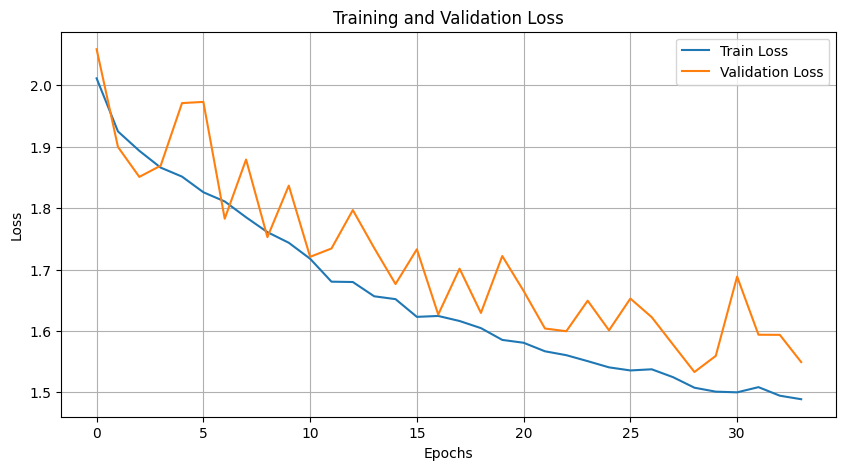

In [ ]:
train_errors_ln_da, val_errors_ln_da = train(
    model=letnet_model,
    optimizer=optimizer,
    criterion=CRITERION,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    do_early_stopping=True,
    patience=5,
    epochs=EPOCHS,
)

plot_taining(train_errors_ln_da, val_errors_ln_da)

In [ ]:
model_calassification_report(letnet_model, test_loader, DEVICE, NUM_CLASSES)

Accuracy: 0.4239

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.47      0.67      0.55       387
           1       0.38      0.41      0.39       395
           2       0.42      0.59      0.49       357
           3       0.68      0.08      0.14       386
           4       0.45      0.52      0.48       409
           5       0.35      0.47      0.40       394
           6       0.60      0.21      0.31       389
           7       0.54      0.13      0.21       419
           8       0.28      0.63      0.39       399
           9       0.86      0.55      0.67       390

    accuracy                           0.42      3925
   macro avg       0.50      0.43      0.40      3925
weighted avg       0.50      0.42      0.40      3925



# **DenseNet**

In [ ]:
class DenseLayer(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob=0.2):
        super(DenseLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels) # Batch Normalization
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)  # Dropout

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.dropout(out)  # Dropout
        return torch.cat([x, out], dim=1)

class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate, dropout_prob=0.2):
        super(DenseBlock, self).__init__()
        layers = []
        for i in range(num_layers):
            layers.append(DenseLayer(in_channels + i * growth_rate, growth_rate, dropout_prob))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob=0.2):
        super(TransitionLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels) # Batch Normalization
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=dropout_prob)  # Dropout

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.dropout(out)  # Dropout
        out = self.pool(out)
        return out

class DenseNet(nn.Module):
    def __init__(self, num_layers, growth_rate=32, num_classes=10, dropout_prob=0.2):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate
        self.num_layers = num_layers
        self.num_blocks = len(num_layers)

        out_channels = growth_rate * 2
        self.conv1 = nn.Conv2d(3, out_channels, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(out_channels) # Batch Normalization
        self.relu = nn.ReLU()

        self.blocks = []
        for i in range(self.num_blocks):
            self.blocks.append(DenseBlock(num_layers[i], out_channels, growth_rate, dropout_prob))
            out_channels += num_layers[i] * growth_rate
            if i < self.num_blocks - 1:
                self.blocks.append(TransitionLayer(out_channels, out_channels // 2, dropout_prob))
                out_channels //= 2
        self.dense = nn.Sequential(*self.blocks)
        self.avpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(out_channels, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dense(x)
        x = self.avpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

densenet_model = DenseNet(num_layers=[6, 12, 24, 16], growth_rate=32, num_classes=10).to(DEVICE)

summary(densenet_model, input_size=(32, 3, 32, 32), depth=4)

Layer (type:depth-idx)                        Output Shape              Param #
DenseNet                                      [32, 10]                  --
├─Conv2d: 1-1                                 [32, 64, 16, 16]          9,472
├─BatchNorm2d: 1-2                            [32, 64, 16, 16]          128
├─ReLU: 1-3                                   [32, 64, 16, 16]          --
├─Sequential: 1-4                             [32, 1024, 2, 2]          --
│    └─DenseBlock: 2-1                        [32, 256, 16, 16]         --
│    │    └─Sequential: 3-1                   [32, 256, 16, 16]         --
│    │    │    └─DenseLayer: 4-1              [32, 96, 16, 16]          18,528
│    │    │    └─DenseLayer: 4-2              [32, 128, 16, 16]         27,744
│    │    │    └─DenseLayer: 4-3              [32, 160, 16, 16]         36,960
│    │    │    └─DenseLayer: 4-4              [32, 192, 16, 16]         46,176
│    │    │    └─DenseLayer: 4-5              [32, 224, 16, 16]         55,

In [ ]:
LR = 0.001
EPOCHS = 50

optimizer = optim.Adam(densenet_model.parameters(), lr=LR)

CRITERION = nn.CrossEntropyLoss().to(DEVICE)

train_loader, val_loader, test_loader, _, _ = get_dataloaders(
    transforms_aug, transform_no_aug, batch_size=32
)

Epoch: 001 | Train Loss: 2.06164 | Val Loss: 2.24159
Epoch: 002 | Train Loss: 1.87856 | Val Loss: 3.39755
Epoch: 003 | Train Loss: 1.76080 | Val Loss: 1.82262
Epoch: 004 | Train Loss: 1.64296 | Val Loss: 1.73601
Epoch: 005 | Train Loss: 1.53576 | Val Loss: 2.19010
Epoch: 006 | Train Loss: 1.47021 | Val Loss: 1.91965
Epoch: 007 | Train Loss: 1.36508 | Val Loss: 2.01089
Epoch: 008 | Train Loss: 1.30297 | Val Loss: 1.34395
Epoch: 009 | Train Loss: 1.24514 | Val Loss: 1.56564
Epoch: 010 | Train Loss: 1.19449 | Val Loss: 1.42415
Epoch: 011 | Train Loss: 1.15173 | Val Loss: 1.30277
Epoch: 012 | Train Loss: 1.12859 | Val Loss: 1.43224
Epoch: 013 | Train Loss: 1.08702 | Val Loss: 1.40159
Epoch: 014 | Train Loss: 1.06416 | Val Loss: 1.13011
Epoch: 015 | Train Loss: 1.03596 | Val Loss: 2.34688
Epoch: 016 | Train Loss: 0.99713 | Val Loss: 1.30704
Epoch: 017 | Train Loss: 0.96622 | Val Loss: 1.23014
Epoch: 018 | Train Loss: 0.95508 | Val Loss: 1.46972
Epoch: 019 | Train Loss: 0.94901 | Val Loss: 1

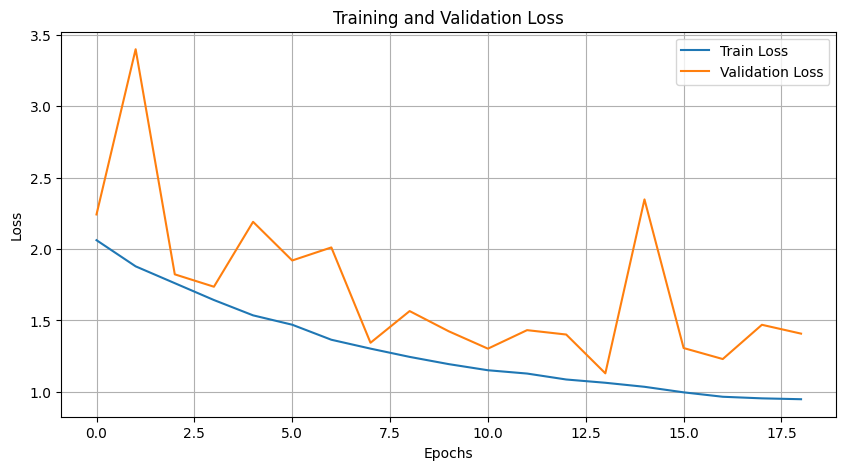

In [ ]:
train_errors_dn, val_errors_dn = train(
    model=densenet_model,
    optimizer=optimizer,
    criterion=CRITERION,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    do_early_stopping=True,
    patience=5,
    epochs=EPOCHS,
)

plot_taining(train_errors_dn, val_errors_dn)

In [ ]:
model_calassification_report(densenet_model, test_loader, DEVICE, NUM_CLASSES)

Accuracy: 0.2645

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.94      0.04      0.08       387
           1       0.33      0.01      0.01       395
           2       0.59      0.21      0.31       357
           3       0.59      0.14      0.23       386
           4       0.32      0.45      0.38       409
           5       0.76      0.07      0.13       394
           6       0.65      0.06      0.11       389
           7       0.63      0.12      0.21       419
           8       0.13      0.83      0.23       399
           9       0.60      0.69      0.64       390

    accuracy                           0.26      3925
   macro avg       0.55      0.26      0.23      3925
weighted avg       0.55      0.26      0.23      3925



# **LeNet tests in W&B**

In [ ]:
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
WANDB_TEAM_NAME = "cardlean94-universidad-ort-uruguay"
WANDB_PROJECT = "tarea_1_taller"

sweep_config = {
    "name": "LeNet_V2",
    "method": "bayes",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "parameters": {
        "learning_rate": {"distribution": "uniform", "min": 0.001, "max": 0.01},
        "dropout_rate": {"values": [0.1, 0.2, 0.3]},
        "optimizer": {"values": ["adam", "sgd"]},
        "batch_size": {"values": [64, 256, 1024]},
        "label_smoothing": {"values": [0, 0.1]}
    },
    "early_terminate": {"type": "hyperband", "min_iter": 10},
}

sweep_id = wandb.sweep(sweep_config, project=WANDB_PROJECT)

Create sweep with ID: htj8rtgk
Sweep URL: https://wandb.ai/cardlean94-universidad-ort-uruguay/tarea_1_taller/sweeps/htj8rtgk


In [ ]:
EPOCHS = 50

In [ ]:
def wand_log(epoch, train_loss, val_loss):
    wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss})

def sweep_run():
    """
    Función que se ejecutará en cada run del sweep.
    """

    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    wandb.init()

    config = wandb.config
    learning_rate = config.learning_rate
    dropout_rate = config.dropout_rate
    optimizer = config.optimizer
    batch_size = config.batch_size
    label_smoothing = config.label_smoothing

    CRITERION = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

    model = LeNet_v2(3, NUM_CLASSES, dropout_rate=dropout_rate).to(DEVICE)

    if optimizer == "adam":
      optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    else:
      optimizer = optim.SGD(model.parameters(), lr=learning_rate)


    train_loader, val_loader, test_loader, _, _ = get_dataloaders(transforms_aug,
                                                                  transform_no_aug,
                                                                  batch_size,
                                                                  NUM_WORKERS,
                                                                  )

    train(
      model=model,
      optimizer=optimizer,
      criterion=CRITERION,
      train_loader=train_loader,
      val_loader=val_loader,
      device=DEVICE,
      do_early_stopping=True,
      patience=5,
      epochs=EPOCHS,
      log_fn=wand_log,
      log_every=1
    )

    torch.save(model.state_dict(), "model.pth")
    wandb.save("model.pth")

    wandb.finish()

In [ ]:
wandb.agent(sweep_id, function=sweep_run, count=10)

wandb: Agent Starting Run: 2xgdj83x with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.2
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.002423786115899135
wandb: 	optimizer: sgd
wandb: Currently logged in as: cardlean94 (cardlean94-universidad-ort-uruguay). Use `wandb login --relogin` to force relogin


Detener entrenamiento en la época 45, la mejor pérdida fue 1.70673


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train_loss,█▇▆▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
val_loss,█▇▆▆▆▅▆▇▅▄▄▄▃▃▄▂▂▂▃▃▂▂▂▂▂▃▂▃▁▂▃▂▁▃▁▁▁▂▁▁
epoch,45
train_loss,1.68176
val_loss,1.73718


wandb: Agent Starting Run: y38e0j6p with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.1
wandb: 	label_smoothing: 0.1
wandb: 	learning_rate: 0.004174462130550529
wandb: 	optimizer: sgd


epoch,▁▂▂▃▄▅▅▆▇▇█
train_loss,█▆▅▄▃▃▃▂▂▁▁
val_loss,█▆▅▄▄▃▃▂▂▁▁
epoch,10
train_loss,2.00826
val_loss,2.01241


wandb: Agent Starting Run: bo26d1hb with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.1
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.0013927671299689404
wandb: 	optimizer: sgd


epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
train_loss,█▆▅▅▄▄▃▃▂▂▂▁▁▁
val_loss,█▆▆▅▄▄▃▃▃▂▂▂▁▁
epoch,13
train_loss,2.04082
val_loss,2.05074


wandb: Agent Starting Run: som83ub7 with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.2
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.009325393263227923
wandb: 	optimizer: adam


Detener entrenamiento en la época 12, la mejor pérdida fue 1.80888


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
train_loss,█▅▄▃▂▂▂▂▂▁▁▂▁
val_loss,▇▅▅█▂▂▄▁▁▄▅█▂
epoch,12
train_loss,1.78461
val_loss,1.8553


wandb: Agent Starting Run: ua7qfcnw with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.1
wandb: 	label_smoothing: 0.1
wandb: 	learning_rate: 0.006227381054478516
wandb: 	optimizer: sgd


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
train_loss,█▆▅▄▄▄▃▃▂▂▂▂▁▁▁▁
val_loss,█▆▅▅▄▄▃▃▂▂▂▂▁▂▄▁
epoch,15
train_loss,1.93764
val_loss,1.94887


wandb: Agent Starting Run: xlxwcy5u with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.3
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.0028471562143887216
wandb: 	optimizer: sgd


epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
train_loss,█▇▅▅▄▄▃▃▃▂▂▁▁▁
val_loss,█▇▆▅▄▄▃▃▂▂▂▂▁▁
epoch,13
train_loss,1.96703
val_loss,1.95968


wandb: Agent Starting Run: 1fmpzdux with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.2
wandb: 	label_smoothing: 0.1
wandb: 	learning_rate: 0.003150669544540139
wandb: 	optimizer: sgd


Detener entrenamiento en la época 30, la mejor pérdida fue 1.84047


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▅▅▅▄▃▅▃▄▃▂▂▃▃▂▂▂▂▂▁▂▃▂▁▁▁▁▄▂
epoch,30
train_loss,1.83177
val_loss,1.86953


wandb: Agent Starting Run: yv90balr with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.2
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.0030256534776268726
wandb: 	optimizer: sgd


epoch,▁▂▂▃▄▅▅▆▇▇█
train_loss,█▆▅▄▄▃▃▂▂▁▁
val_loss,█▆▅▄▄▃▃▂▂▁▁
epoch,10
train_loss,1.98713
val_loss,1.98564


wandb: Agent Starting Run: 84tll8tl with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.3
wandb: 	label_smoothing: 0.1
wandb: 	learning_rate: 0.0025824655088535218
wandb: 	optimizer: sgd


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
train_loss,█▆▅▄▃▃▃▂▂▂▂▂▁▁▁▁
val_loss,█▆▅▄▄▃▃▃▃▄▃▂▃▆▁▆
epoch,15
train_loss,1.90487
val_loss,2.06419


wandb: Agent Starting Run: dncpundp with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.2
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.0033013008655188663
wandb: 	optimizer: sgd


Detener entrenamiento en la época 21, la mejor pérdida fue 1.76725


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
train_loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
val_loss,█▇▆▅▅▄▃▂▃▄▅▄▂▂▂▃▁▁▂▃▁▂
epoch,21
train_loss,1.74549
val_loss,1.79685


In [ ]:
api = wandb.Api()

# nos traemos el sweep (objeto) para analizar los resultados
sweep = api.sweep(f"{WANDB_TEAM_NAME}/{WANDB_PROJECT}/{sweep_id}")

# obtenemos el mejor run
best_run = sweep.best_run()

# imprimimos el mejor run
print(f"Best run {best_run.name} with {best_run.summary['val_loss']}")

# descargamos el modelo del mejor run
best_run.file("model.pth").download(replace=True)

wandb: Sorting runs by +summary_metrics.val_loss


Best run pious-sweep-1 with 1.737184504667918


<_io.TextIOWrapper name='./model.pth' mode='r' encoding='UTF-8'>

In [ ]:
# restauramos el modelo
letnet_model.load_state_dict(torch.load("model.pth"))

# Evaluamos el modelo en el conjunto de test
test_loss = evaluate(letnet_model, CRITERION, test_loader, DEVICE)

print(f"Test Loss: {test_loss:.5f}")

<ipython-input-27-fbbd558b4471>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  letnet_model.load_state_dict(torch.load("model.pth"))


Test Loss: 2.15406


In [ ]:
model_calassification_report(letnet_model, test_loader, DEVICE, NUM_CLASSES)

Accuracy: 0.2991

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.35      0.48      0.41       387
           1       0.29      0.14      0.19       395
           2       0.43      0.31      0.36       357
           3       0.40      0.03      0.05       386
           4       0.27      0.53      0.35       409
           5       0.24      0.72      0.35       394
           6       0.24      0.45      0.32       389
           7       0.24      0.01      0.02       419
           8       0.48      0.07      0.13       399
           9       0.94      0.26      0.41       390

    accuracy                           0.30      3925
   macro avg       0.39      0.30      0.26      3925
weighted avg       0.39      0.30      0.26      3925



# **LeNet W&B results:**

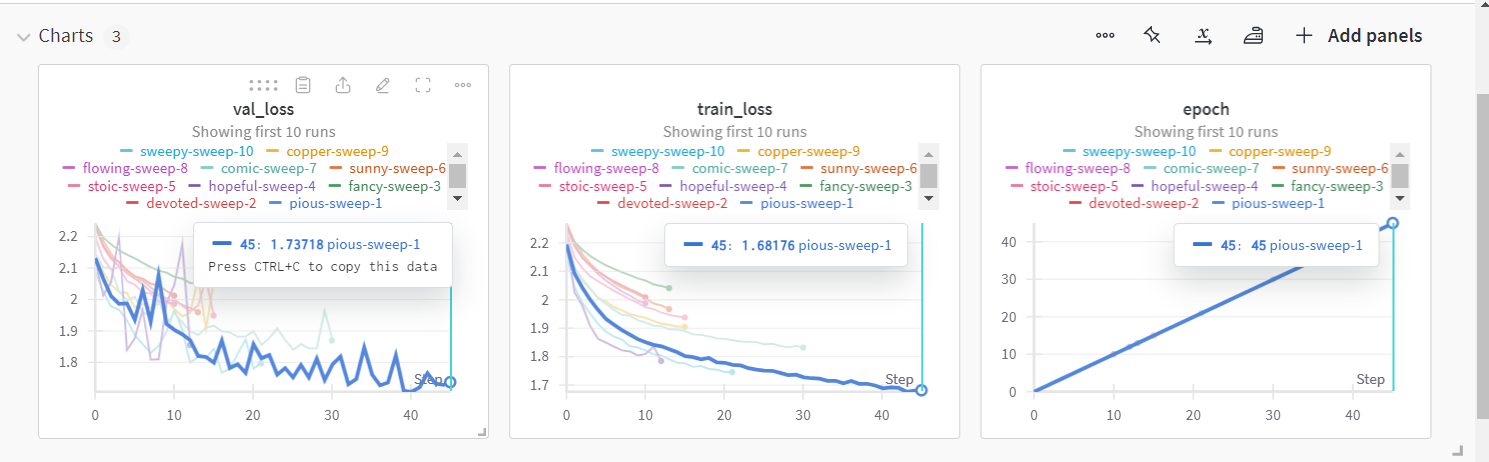

In [ ]:
display(Image(filename='/content/Test_results/LeNet1.png'))

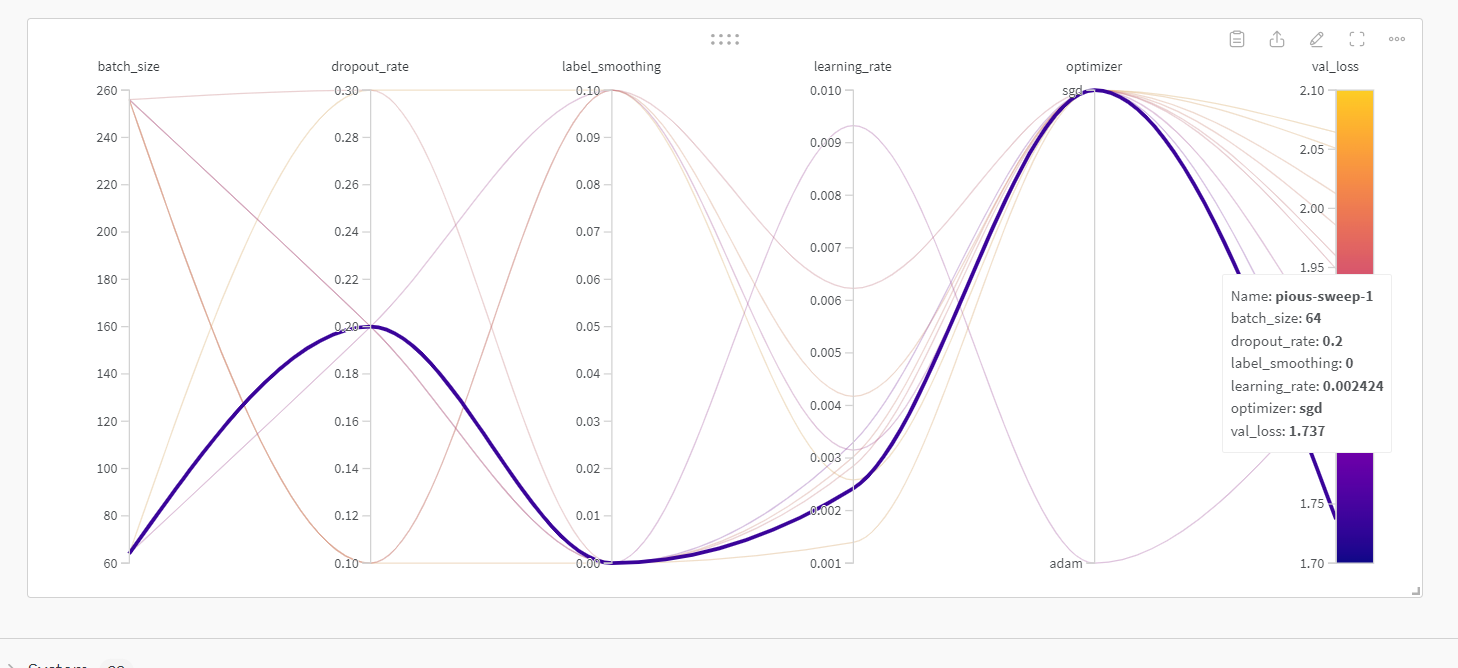

In [ ]:
display(Image(filename='/content/Test_results/LeNet2.png'))

# **DenseNet Test in W&B**

In [ ]:
WANDB_TEAM_NAME = "cardlean94-universidad-ort-uruguay"
WANDB_PROJECT = "tarea_1_taller"

sweep_config = {
    "name": "DenseNet-Tests",
    "method": "bayes",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "parameters": {
        "learning_rate": {"distribution": "uniform", "min": 0.001, "max": 0.01},
        "dropout_rate": {"values": [0.1, 0.2, 0.3]},
        "optimizer": {"values": ["adam", "sgd"]},
        "batch_size": {"values": [32, 64]},
        "label_smoothing": {"values": [0, 0.1]}
    },
    "early_terminate": {"type": "hyperband", "min_iter": 10},
}

sweep_id = wandb.sweep(sweep_config, project=WANDB_PROJECT)

Create sweep with ID: jut81186
Sweep URL: https://wandb.ai/cardlean94-universidad-ort-uruguay/tarea_1_taller/sweeps/jut81186


In [ ]:
EPOCHS = 50

In [ ]:
def wand_log(epoch, train_loss, val_loss):
    wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss})

def sweep_run():
    """
    Función que se ejecutará en cada run del sweep.
    """

    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    wandb.init()

    config = wandb.config
    learning_rate = config.learning_rate
    dropout_rate = config.dropout_rate
    optimizer = config.optimizer
    batch_size = config.batch_size
    label_smoothing = config.label_smoothing

    CRITERION = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

    model = DenseNet(num_layers=[6, 12, 24, 16], growth_rate=32, num_classes=10).to(DEVICE)

    if optimizer == "adam":
      optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    else:
      optimizer = optim.SGD(model.parameters(), lr=learning_rate)


    train_loader, val_loader, test_loader, _, _ = get_dataloaders(transforms_aug,
                                                                  transform_no_aug,
                                                                  batch_size,
                                                                  NUM_WORKERS,
                                                                  )

    train(
      model=model,
      optimizer=optimizer,
      criterion=CRITERION,
      train_loader=train_loader,
      val_loader=val_loader,
      device=DEVICE,
      do_early_stopping=True,
      patience=5,
      epochs=EPOCHS,
      log_fn=wand_log,
      log_every=1
    )

    torch.save(model.state_dict(), "model_dense.pth")
    wandb.save("model_dense.pth")

    wandb.finish()

In [ ]:
wandb.agent(sweep_id, function=sweep_run, count=10)

wandb: Agent Starting Run: ix6rus1y with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.2
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.0029427220882936997
wandb: 	optimizer: sgd


Detener entrenamiento en la época 7, la mejor pérdida fue 2.09418


epoch,▁▂▃▄▅▆▇█
train_loss,█▆▅▄▃▂▂▁
val_loss,▂▁▁▃█▇▄▄
epoch,7
train_loss,1.72215
val_loss,2.31803


wandb: Agent Starting Run: xgnwf91m with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.007865137033840158
wandb: 	optimizer: adam


Detener entrenamiento en la época 20, la mejor pérdida fue 1.03570


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
train_loss,█▇▆▅▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁
val_loss,▅▄▄▄▆█▂▄▂▂▇▁▁▁▂▁▁▁▂▁▂
epoch,20
train_loss,0.87916
val_loss,1.29829


wandb: Agent Starting Run: suddfyeg with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.1
wandb: 	label_smoothing: 0.1
wandb: 	learning_rate: 0.008081196908831249
wandb: 	optimizer: sgd


epoch,▁▂▂▃▄▅▅▆▇▇█
train_loss,█▆▅▄▃▃▂▂▂▁▁
val_loss,▇▆▅█▄▆▃▅▂▁▃
epoch,10
train_loss,1.43674
val_loss,1.84926


wandb: Agent Starting Run: nngtqgcx with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.1
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.004620587638657733
wandb: 	optimizer: sgd


Detener entrenamiento en la época 5, la mejor pérdida fue 2.44850


epoch,▁▂▄▅▇█
train_loss,█▅▄▃▂▁
val_loss,▁▄▅▆█▆
epoch,5
train_loss,1.70787
val_loss,4.08352


wandb: Agent Starting Run: 7lajhtmc with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.2
wandb: 	label_smoothing: 0.1
wandb: 	learning_rate: 0.0031765365963543485
wandb: 	optimizer: sgd


Detener entrenamiento en la época 6, la mejor pérdida fue 2.19046


epoch,▁▂▃▅▆▇█
train_loss,█▆▄▃▂▂▁
val_loss,▂▁▁▅▅▄█
epoch,6
train_loss,1.88862
val_loss,4.042


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f399gwz2 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.1
wandb: 	label_smoothing: 0.1
wandb: 	learning_rate: 0.004851311693112012
wandb: 	optimizer: adam


epoch,▁▂▂▃▄▅▅▆▇▇█
train_loss,█▆▆▅▄▃▂▂▂▁▁
val_loss,█▇▅▄▃▄▃▂▄▄▁
epoch,10
train_loss,1.42118
val_loss,1.57516


wandb: Agent Starting Run: u4m2aq9c with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.008553629666136636
wandb: 	optimizer: sgd


epoch,▁▂▂▃▄▄▅▅▆▇▇█
train_loss,█▆▅▅▄▃▃▂▂▂▁▁
val_loss,██▄▂▄▃▂▃▁▂▁▁
epoch,11
train_loss,1.12794
val_loss,1.25535


wandb: Agent Starting Run: rz23ykji with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.3
wandb: 	label_smoothing: 0.1
wandb: 	learning_rate: 0.004253870751408267
wandb: 	optimizer: adam


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▆▅▄▃▃▂▁▁
val_loss,█▄▂▂▁▅▁▄▇▇
epoch,9
train_loss,1.4898
val_loss,2.77937


wandb: Agent Starting Run: r5koa4ip with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.00890945568498137
wandb: 	optimizer: adam


Detener entrenamiento en la época 22, la mejor pérdida fue 1.02504


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
train_loss,█▇▆▆▅▅▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
val_loss,▂▂▂▂▂▂▂▂▂▁█▁▂▁▁▁▁▁▁▁▁▂▁
epoch,22
train_loss,0.89334
val_loss,1.3567


wandb: Agent Starting Run: jtuir8ig with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	label_smoothing: 0.1
wandb: 	learning_rate: 0.008827136951244308
wandb: 	optimizer: sgd


epoch,▁▂▂▃▄▅▅▆▇▇█
train_loss,█▆▅▄▃▃▂▂▂▁▁
val_loss,█▅▅▃▅▄▂▁▁▂▁
epoch,10
train_loss,1.40473
val_loss,1.56341


In [ ]:
api = wandb.Api()

# nos traemos el sweep (objeto) para analizar los resultados
sweep = api.sweep(f"{WANDB_TEAM_NAME}/{WANDB_PROJECT}/{sweep_id}")

# obtenemos el mejor run
best_run = sweep.best_run()

# imprimimos el mejor run
print(f"Best run {best_run.name} with {best_run.summary['val_loss']}")

# descargamos el modelo del mejor run
best_run.file("model_dense.pth")

wandb: Sorting runs by +summary_metrics.val_loss


Best run atomic-sweep-7 with 1.255354034900665


<File model_dense.pth (None) 0.0B>

In [ ]:
# restauramos el modelo
densenet_model.load_state_dict(torch.load("model_dense.pth"))

# Evaluamos el modelo en el conjunto de test
test_loss = evaluate(densenet_model, CRITERION, test_loader, DEVICE)

print(f"Test Loss: {test_loss:.5f}")

<ipython-input-38-66bdd7f9a466>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  densenet_model.load_state_dict(torch.load("model_dense.pth"))


Test Loss: 2.83060


In [ ]:
model_calassification_report(densenet_model, test_loader, DEVICE, NUM_CLASSES)

Accuracy: 0.2989

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.83      0.11      0.20       387
           1       0.60      0.02      0.04       395
           2       0.42      0.28      0.33       357
           3       0.48      0.04      0.07       386
           4       0.19      0.74      0.30       409
           5       0.38      0.09      0.15       394
           6       0.31      0.01      0.02       389
           7       0.31      0.44      0.37       419
           8       0.29      0.52      0.37       399
           9       0.50      0.69      0.58       390

    accuracy                           0.30      3925
   macro avg       0.43      0.29      0.24      3925
weighted avg       0.43      0.30      0.24      3925



# **DenseNet W&B Results:**

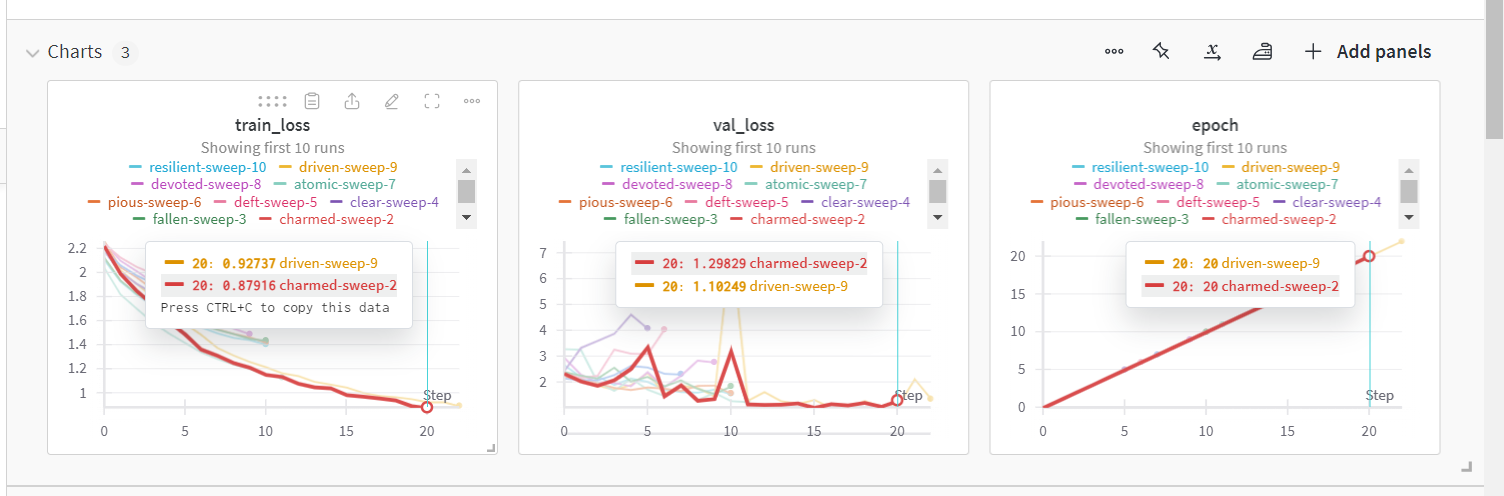

In [ ]:
display(Image(filename='/content/Test_results/Dense1.png'))

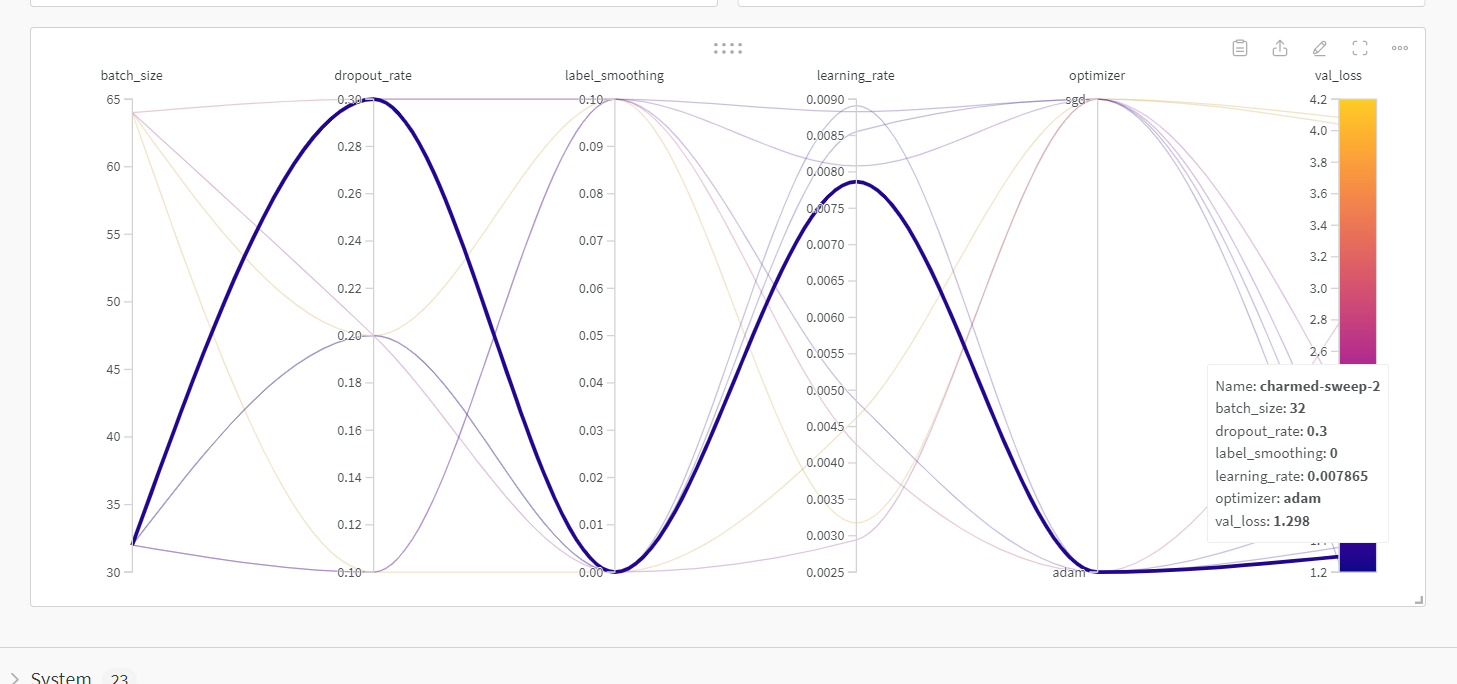

In [ ]:
display(Image(filename='/content/Test_results/Dense2.png'))